In [1]:
library(MCMCglmm)
library(lme4) #random effect'lmerTest' should be used in place of 'lme4', If lmer model p-values are desired 
library(brms) #preditability with baysian approach
library(ggplot2) #plot
library(MuMIn) #r.squaredGLMM
library(merTools) #simulations
library(optimx) #different optimizer to help model to converge 
#library("posterior") #not sue I am using it as brms should have it already in its package, althought it is base don this package

Warning message:
"package 'MCMCglmm' was built under R version 4.0.5"
Loading required package: Matrix

Loading required package: coda

Warning message:
"package 'coda' was built under R version 4.0.5"
Loading required package: ape

Warning message:
"package 'brms' was built under R version 4.0.5"
Loading required package: Rcpp

Loading 'brms' package (version 2.16.1). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: 'brms'


The following object is masked from 'package:lme4':

    ngrps


The following object is masked from 'package:MCMCglmm':

    me


The following object is masked from 'package:stats':

    ar


Warning message:
"package 'MuMIn' was built under R version 4.0.5"

Attaching package: 'MuMIn'


The following object is masked from 'package:brms':

    loo


Warning message:
"package 'merTools' was built under R version 4.0.5"
Loading required package:

In [2]:
#citation("merTools")

In [3]:
library(parallel)
my.cores = detectCores()

library(lme4)
library(arm)
library(MuMIn)
library(tidyverse)
library(plyr)
library(broom)
library(coda)
library(grid)
library(gridExtra)
library(brms)
library(broom.mixed)
library(merTools)
library(tidybayes)
library(parallel)

# Download data

In [4]:
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/ALLDATA_'
path_adapt = file.path(path_,'Adaptability')
path_model = file.path(path_adapt,'repeatability_model')
df = read.csv(file.path(path_adapt,'df_MVT_4individuality_withPCA.csv'), header = TRUE, sep = ",")
df$HenID = as.factor(df$HenID)   
df$PenID = as.factor(df$PenID) 
df$WIB = as.factor(df$WIB) 
df$TrackingSystemID = as.factor(df$TrackingSystemID) 
#mean-centering of the environmental variable so that intercepts reflect average values for the population and individuals
df$cDIB = as.integer(df$DIB) 
df$RearingPenID = as.factor(df$RearingPenID) 
df$CLASS = as.factor(df$CLASS) 
df$Treatment = as.factor(df$Treatment) 
#scale
df$temperature_C_avg_scale = scale(df$temperature_C_avg, center=TRUE, scale=TRUE)
df$cDIB_scale = scale(df$cDIB, center=TRUE, scale=TRUE)
df$avgDIB_scale = scale(df$avgDIB, center=TRUE, scale=TRUE)
print(dim(df))
summary(df)

[1] 5259   34


 WIB         HenID           RPen            DIB          CLASS     
 2:328   hen_1  :  43   Min.   :1.000   Min.   :11.00   LEXP :1043  
 3:777   hen_105:  43   1st Qu.:2.000   1st Qu.:23.00   MEXP :1421  
 4:874   hen_110:  43   Median :2.000   Median :34.00   Other:2795  
 5:910   hen_113:  43   Mean   :2.479   Mean   :33.58               
 6:814   hen_114:  43   3rd Qu.:3.000   3rd Qu.:44.00               
 7:910   hen_116:  43   Max.   :4.000   Max.   :54.00               
 8:646   (Other):5001                                               
             TrackingSystemID     PenID      temperature_C_avg Treatment  
 TrackingSystem 10-12:2138    pen10  : 756   Min.   : 4.000    OFH :2569  
 TrackingSystem 3-5  :1746    pen11  : 756   1st Qu.: 8.667    TRAN:2690  
 TrackingSystem 8-9  :1375    pen8   : 688   Median :11.000               
                              pen9   : 687   Mean   :10.841               
                              pen12  : 626   3rd Qu.:12.667              

In [5]:
length(unique(df[['HenID']]))

[1] 130

# LPenID/Class/RPenID effects

modeltestinit1 = lmer(PC1 ~ Treatment + (1|HenID), REML = TRUE, data = df)
summary(modeltestinit1)
r.squaredGLMM(modeltestinit1)

modeltest1 = lmer(PC1 ~ Treatment + (1|PenID/HenID), REML = TRUE, data = df)
summary(modeltest1)
r.squaredGLMM(modeltest1)

AIC(modeltestinit1, modeltest1)

In [6]:
#test other fixed effects
#highest hierarchical level: HenID. Test all other factors starting with the most biologically relevant and keeping it 
#if significant
modeltestinit = lmer(PC1 ~ 1 + (1|HenID), REML = FALSE, data = df)
summary(modeltestinit)
r.squaredGLMM(modeltestinit)

modeltest1 = lmer(PC1 ~ Treatment_encoded + (1|HenID), REML = FALSE, data = df)
summary(modeltest1)
r.squaredGLMM(modeltest1)

modeltest2 = lmer(PC1 ~  Treatment_encoded + PenID + (1|HenID), REML = FALSE, data = df)
summary(modeltest2)
r.squaredGLMM(modeltest2)

#RELM cant be true if we compare a fixed effect across two models
modeltest3 = lmer(PC1 ~ Treatment_encoded + RearingPenID + (1|HenID), REML = FALSE, data = df)
summary(modeltest3)
r.squaredGLMM(modeltest3)

modeltest4 = lmer(PC1 ~ Treatment_encoded + CLASS + (1|HenID), REML = FALSE, data = df)
summary(modeltest4)
r.squaredGLMM(modeltest4)

#The lower the AIC value, the more parsimonious the fit of the model is to the data
anova(modeltest1, modeltestinit, test="Chisq")
anova(modeltest2, modeltest1, test="Chisq")
anova(modeltest3, modeltest1, test="Chisq")
anova(modeltest4, modeltest1, test="Chisq")
#LRT : p>0.05--> use simpler model

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: PC1 ~ 1 + (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 11863.9  11883.6  -5928.9  11857.9     5256 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6312 -0.5594  0.0566  0.6139  3.6410 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.4497   0.6706  
 Residual             0.5107   0.7146  
Number of obs: 5259, groups:  HenID, 130

Fixed effects:
             Estimate Std. Error t value
(Intercept) -0.001898   0.059640  -0.032

Warning message:
"'r.squaredGLMM' now calculates a revised statistic. See the help page."


R2m,R2c
0,0.468252


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: PC1 ~ Treatment_encoded + (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 11853.0  11879.3  -5922.5  11845.0     5255 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6189 -0.5637  0.0580  0.6142  3.6340 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.4062   0.6373  
 Residual             0.5107   0.7146  
Number of obs: 5259, groups:  HenID, 130

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       -0.002061   0.056764  -0.036
Treatment_encoded -0.208757   0.056764  -3.678

Correlation of Fixed Effects:
            (Intr)
Trtmnt_ncdd 0.001 

R2m,R2c
0.04536045,0.4682785


fixed-effect model matrix is rank deficient so dropping 1 column / coefficient



Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: PC1 ~ Treatment_encoded + PenID + (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 11856.7  11922.4  -5918.4  11836.7     5249 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6218 -0.5659  0.0556  0.6154  3.6471 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.3803   0.6167  
 Residual             0.5107   0.7146  
Number of obs: 5259, groups:  HenID, 130

Fixed effects:
                  Estimate Std. Error t value
(Intercept)       -0.05594    0.10761  -0.520
Treatment_encoded -0.35421    0.10761  -3.292
PenIDpen11         0.32961    0.21522   1.532
PenIDpen12        -0.07206    0.21903  -0.329
PenIDpen3          0.32761    0.22522   1.455
PenIDpen4          0.08664    0.21540   0.402
PenIDpen5          0.13159    0.22193   0.593
PenIDpen8         -0.39048    0.21521  -1.814

Correlation of Fixed Effects:
            (Intr) Trtmn_ PnID11 PnID12 P

R2m,R2c
0.07182147,0.4680176


fixed-effect model matrix is rank deficient so dropping 1 column / coefficient



Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: PC1 ~ Treatment_encoded + RearingPenID + (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 11855.4  11894.8  -5921.7  11843.4     5253 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6203 -0.5653  0.0572  0.6143  3.6308 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.4009   0.6331  
 Residual             0.5107   0.7146  
Number of obs: 5259, groups:  HenID, 130

Fixed effects:
                  Estimate Std. Error t value
(Intercept)       -0.03215    0.08448  -0.381
Treatment_encoded -0.13155    0.08448  -1.557
RearingPenID2      0.18852    0.16101   1.171
RearingPenID3     -0.08751    0.16007  -0.547

Correlation of Fixed Effects:
            (Intr) Trtmn_ RrPID2
Trtmnt_ncdd -0.034              
RearngPnID2 -0.542  0.542       
RearngPnID3 -0.510 -0.510  0.000
fit warnings:
fixed-effect model matrix is rank deficient so dropping 1 column / coeff

R2m,R2c
0.05085666,0.468253


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: PC1 ~ Treatment_encoded + CLASS + (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 11855.5  11894.9  -5921.8  11843.5     5253 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6186 -0.5637  0.0578  0.6123  3.6341 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.4014   0.6335  
 Residual             0.5107   0.7146  
Number of obs: 5259, groups:  HenID, 130

Fixed effects:
                  Estimate Std. Error t value
(Intercept)       -0.12185    0.12629  -0.965
Treatment_encoded -0.20624    0.05648  -3.652
CLASSMEXP          0.20523    0.16672   1.231
CLASSOther         0.12156    0.14818   0.820

Correlation of Fixed Effects:
            (Intr) Trtmn_ CLASSM
Trtmnt_ncdd -0.034              
CLASSMEXP   -0.758  0.036       
CLASSOther  -0.852  0.035  0.646

R2m,R2c
0.05037348,0.468282


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
modeltestinit,3,11863.88,11883.59,-5928.942,11857.88,NA,NA,NA
modeltest1,4,11853.02,11879.29,-5922.508,11845.02,12.86812,1,0.0003342276


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
modeltest1,4,11853.02,11879.29,-5922.508,11845.02,NA,NA,NA
modeltest2,10,11856.74,11922.41,-5918.368,11836.74,8.278386,6,0.2184093


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
modeltest1,4,11853.02,11879.29,-5922.508,11845.02,NA,NA,NA
modeltest3,6,11855.36,11894.76,-5921.678,11843.36,1.659152,2,0.4362343


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
modeltest1,4,11853.02,11879.29,-5922.508,11845.02,NA,NA,NA
modeltest4,6,11855.51,11894.91,-5921.754,11843.51,1.507712,2,0.4705487


In [12]:
modeltest2 = lmer(PC1 ~  Treatment_encoded + PenID + CLASS + RearingPenID + (1|HenID), REML = FALSE, data = df)
summary(modeltest2)
r.squaredGLMM(modeltest2)

fixed-effect model matrix is rank deficient so dropping 2 columns / coefficients



Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: PC1 ~ Treatment_encoded + PenID + CLASS + RearingPenID + (1 |  
    HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 11860.7  11952.6  -5916.3  11832.7     5245 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6226 -0.5675  0.0557  0.6146  3.6440 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.3682   0.6068  
 Residual             0.5107   0.7146  
Number of obs: 5259, groups:  HenID, 130

Fixed effects:
                  Estimate Std. Error t value
(Intercept)       -0.23461    0.16210  -1.447
Treatment_encoded -0.27046    0.12110  -2.233
PenIDpen11         0.33511    0.21281   1.575
PenIDpen12        -0.08320    0.21576  -0.386
PenIDpen3          0.32984    0.22199   1.486
PenIDpen4          0.07061    0.21243   0.332
PenIDpen5          0.14585    0.21881   0.667
PenIDpen8         -0.39670    0.21239  -1.868
CLASSMEXP          0.26807    0.16347   1.6

R2m,R2c
0.08454518,0.4680566


# Individual personality

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: 
PC1 ~ cDIB_scale + avgDIB_scale + Treatment_encoded + temperature_C_avg_scale +  
    (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 11569.2  11615.2  -5777.6  11555.2     5252 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2844 -0.5936  0.0272  0.6376  4.0262 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.3945   0.6281  
 Residual             0.4830   0.6950  
Number of obs: 5259, groups:  HenID, 130

Fixed effects:
                         Estimate Std. Error t value
(Intercept)             -0.006949   0.055975  -0.124
cDIB_scale               0.169348   0.010002  16.931
avgDIB_scale             0.100770   0.055592   1.813
Treatment_encoded       -0.217076   0.056055  -3.873
temperature_C_avg_scale  0.073716   0.009990   7.379

Correlation of Fixed Effects:
            (Intr) cDIB_s avDIB_ Trtmn_
cDIB_scale   0.000                     
avgD

R2m,R2c
0.0863942,0.4971605


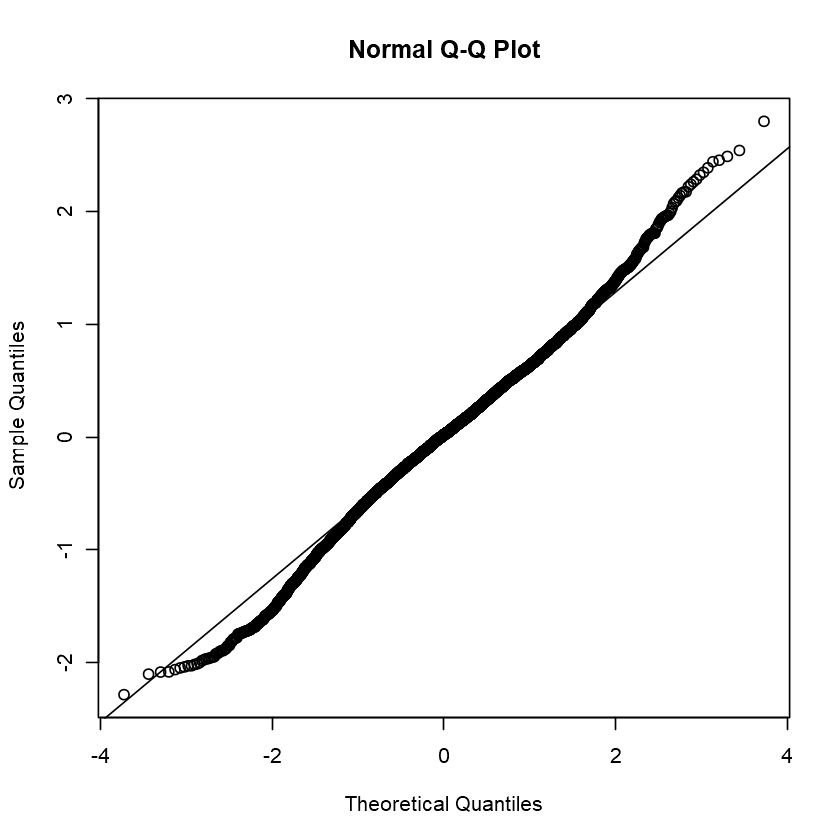

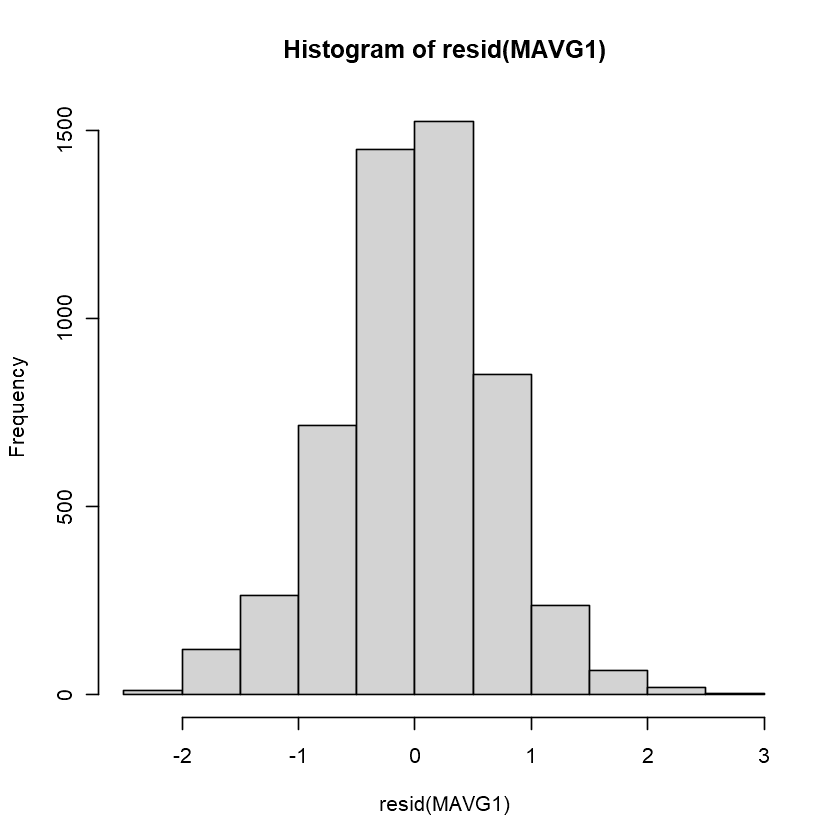

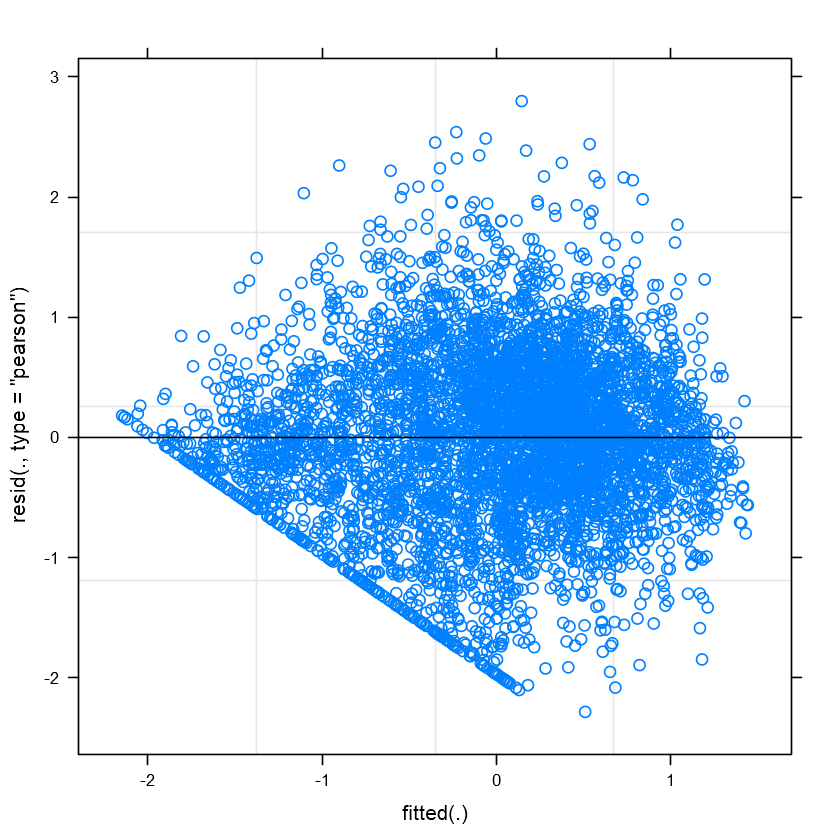

In [7]:
MAVG1 = lmer(PC1 ~ cDIB_scale + avgDIB_scale + Treatment_encoded + temperature_C_avg_scale + (1|HenID), REML=FALSE, data = df)
summary(MAVG1)
r.squaredGLMM(MAVG1)
###### normally distributed residuals
qqnorm(resid(MAVG1))
qqline(resid(MAVG1))
hist(resid(MAVG1))
######check homogeneity of variance (residuals has constant variance)
plot(MAVG1)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: PC1 ~ cDIB_scale + avgDIB_scale + InitialWeight + I(cDIB_scale^2) +  
    Treatment_encoded + temperature_C_avg_scale + (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 11147.6  11206.7  -5564.8  11129.6     5250 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1761 -0.5870  0.0097  0.5985  4.2387 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.3934   0.6272  
 Residual             0.4446   0.6668  
Number of obs: 5259, groups:  HenID, 130

Fixed effects:
                          Estimate Std. Error t value
(Intercept)             -0.4068227  1.0814460  -0.376
cDIB_scale               0.1284117  0.0097915  13.115
avgDIB_scale             0.0968163  0.0555853   1.742
InitialWeight            0.0005425  0.0009235   0.587
I(cDIB_scale^2)         -0.2341358  0.0111199 -21.056
Treatment_encoded       -0.2194794  0.0566835  -3.872
temperature_C_avg_scal

R2m,R2c
0.1265975,0.536639


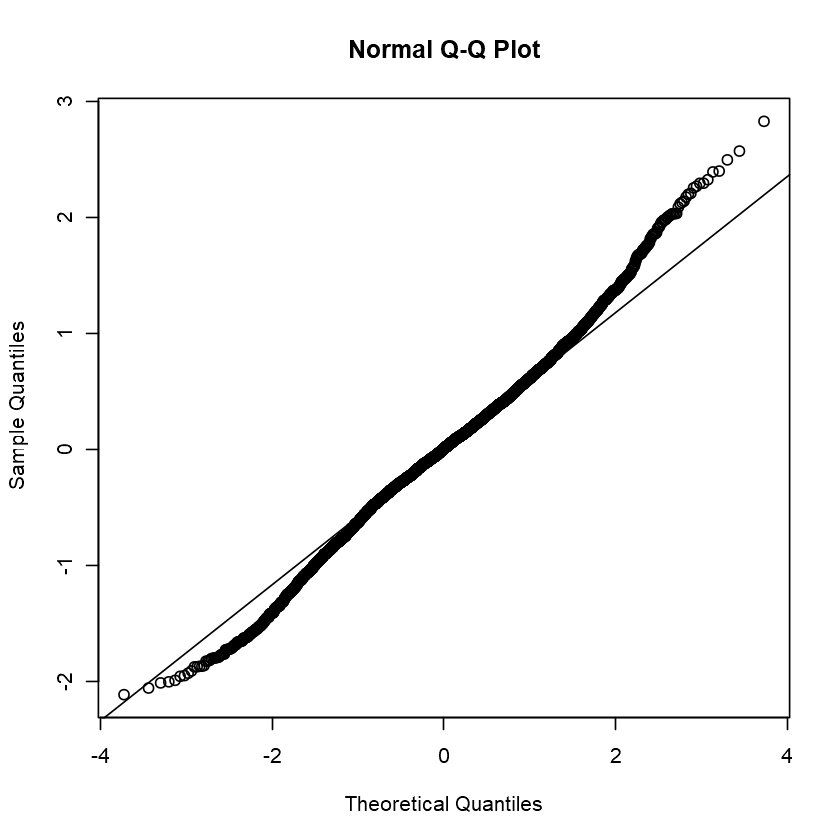

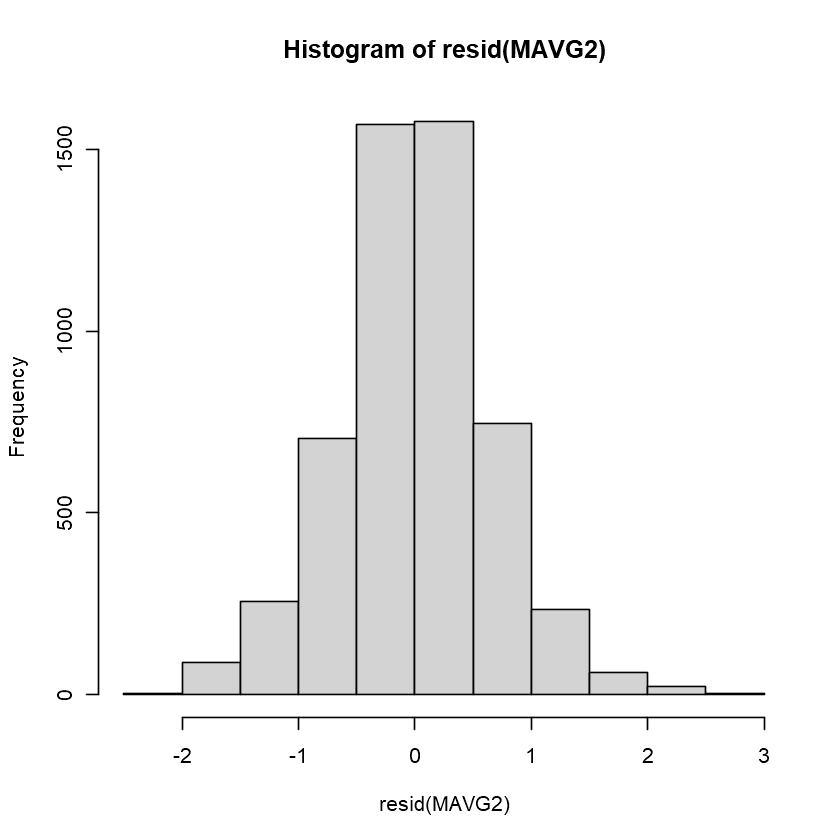

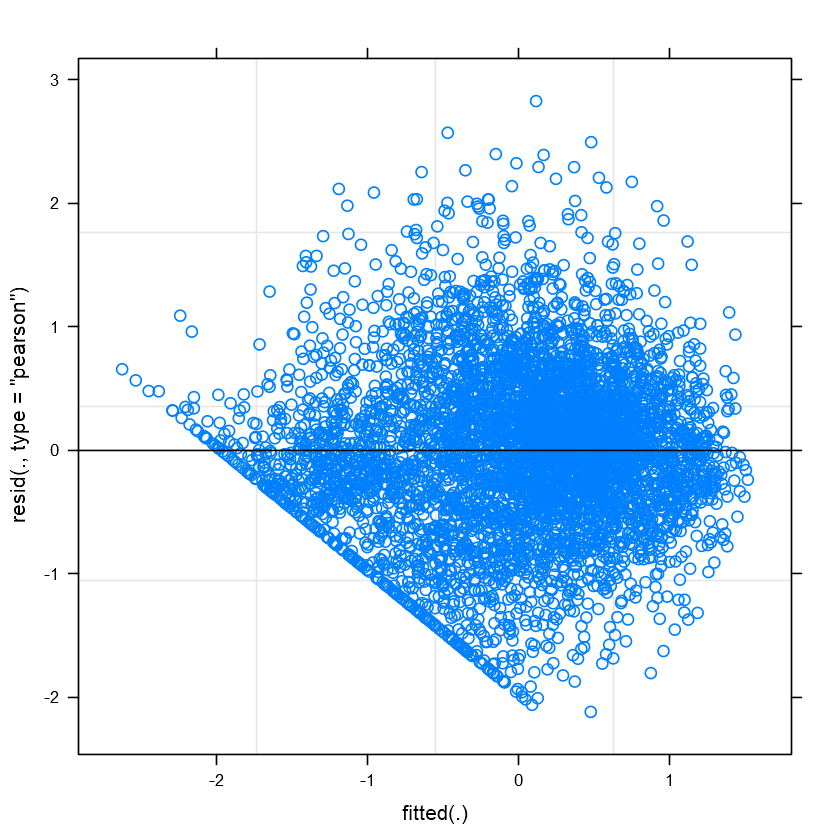

In [8]:
#we use raw=TRUE to be comparable, but then we will set it to FALSE to avoid collineartiy issues
#poly(cDIB, 2, raw = FALSE)1 is the slope coefficient of the quadratic function 
#poly(cDIB, 2, raw = FALSE)2 is the quadratic coefficient of the quadratic functionthat reflects the curvature of the regression
MAVG2 = lmer(PC1 ~ cDIB_scale + avgDIB_scale + I(cDIB_scale^2) + Treatment_encoded + temperature_C_avg_scale + (1|HenID), REML=FALSE, data = df)
summary(MAVG2)
r.squaredGLMM(MAVG2)
###### normally distributed residuals
qqnorm(resid(MAVG2))
qqline(resid(MAVG2))
hist(resid(MAVG2))
######check homogeneity of variance (residuals has constant variance)
plot(MAVG2)

## Comparing models & repeatabilities & save corresponding data

In [9]:
anova(MAVG2, MAVG1, test="Chisq")

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MAVG1,7,11569.19,11615.16,-5777.594,11555.19,NA,NA,NA
MAVG2,9,11147.63,11206.74,-5564.815,11129.63,425.5586,2,3.900562e-93


In [10]:
#repeatabilities
print(VarCorr(MAVG2),comp =c("Variance","Std.Dev."))
rep = VarCorr(MAVG2)$"HenID"[1]/
(VarCorr(MAVG2)$"HenID"[1]+
 attr(VarCorr(MAVG2), "sc")^2) # equal to the variance of residual
#alternatively: 0.39815  /(0.39815  +0.47685)
rep

 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.39342  0.62723 
 Residual             0.44458  0.66677 


[1] 0.469476

In [11]:
#or with posterior distribtion with 1000 simulations and credible interval
set.seed(1)
simulated = sim(MAVG2, n.sim = 1000)
posterior_HenID = apply(simulated@ranef$"HenID"[ , , 1],1,var)
posterior_residual  = simulated@sigma^2
quantile(posterior_HenID/
         (posterior_HenID+posterior_residual), prob=c(0.025, 0.5, 0.975))

2.5%       50%     97.5% 
0.4570533 0.4761509 0.4946413

In [18]:
#BLUP intercepts: behavioural type individual estiamtes with mer-Tools (obtaining repeated samples from the posterior distribution
#of the model from which we can calculate the stdev for each individual)
#as PC1 is not interpretable as much as "total distance travelled" would, we wont add the population-level estimate
#done in "studing..."
#as for our purpose it wont change anything
set.seed(1)
simulated_individualbehaviouraltype = REsim(MAVG2, n.sims = 1000)
head(simulated_individualbehaviouraltype,3)
write.csv(simulated_individualbehaviouraltype,file.path(path_,'Adaptability','IndividualBehaviouralType.csv'),row.names = FALSE)

,groupFctr,groupID,term,mean,median,sd
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,HenID,hen_1,(Intercept),-0.7637702,-0.7685469,0.1408403
2,HenID,hen_10,(Intercept),-0.3345106,-0.3279714,0.1293580
3,HenID,hen_101,(Intercept),0.6250352,0.6286099,0.1434693


### early short-term consistency

modelSTCon = lmer(vertical_travel_distance_perh ~ cDIB + Treatment + temperature_C_avg + InitialWeight_kg + (1|HenID), 
               REML=TRUE, data=df[ which(df$WIB==1), ])
summary(modelSTCon)
r.squaredGLMM(modelSTCon)

#normally distributed residuals
qqnorm(resid(modelBT))
qqline(resid(modelBT))
hist(resid(modelBT))
#check homogeneity of variance (residuals has constant variance)
plot(modelBT)

#repeatabilities
print(VarCorr(modelBT),comp =c("Variance","Std.Dev."))
rep = VarCorr(modelBT)$"HenID"[1]/
(VarCorr(modelBT)$"HenID"[1]+
 attr(VarCorr(modelBT), "sc")^2) # equal to the variance of residual
#alternatively: 0.39815  /(0.39815  +0.47685)
rep

# Plasticity

Linear mixed model fit by REML ['lmerMod']
Formula: 
PC1 ~ cDIB_scale + avgDIB_scale + I(cDIB_scale^2) + Treatment_encoded +  
    temperature_C_avg_scale + (1 + cDIB_scale | HenID)
   Data: df

REML criterion at convergence: 9595.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8286 -0.5865 -0.0263  0.5658  5.2390 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 HenID    (Intercept) 0.4081   0.6388        
          cDIB_scale  0.1388   0.3726   -0.17
 Residual             0.3043   0.5516        
Number of obs: 5259, groups:  HenID, 130

Fixed effects:
                         Estimate Std. Error t value
(Intercept)              0.230992   0.057345   4.028
cDIB_scale               0.129311   0.033672   3.840
avgDIB_scale             0.102008   0.055401   1.841
I(cDIB_scale^2)         -0.238803   0.009246 -25.827
Treatment_encoded       -0.205740   0.055869  -3.683
temperature_C_avg_scale -0.027777   0.008870  -3.131

Correlation of Fixed Effects:
     

R2m,R2c
0.1241562,0.6868801


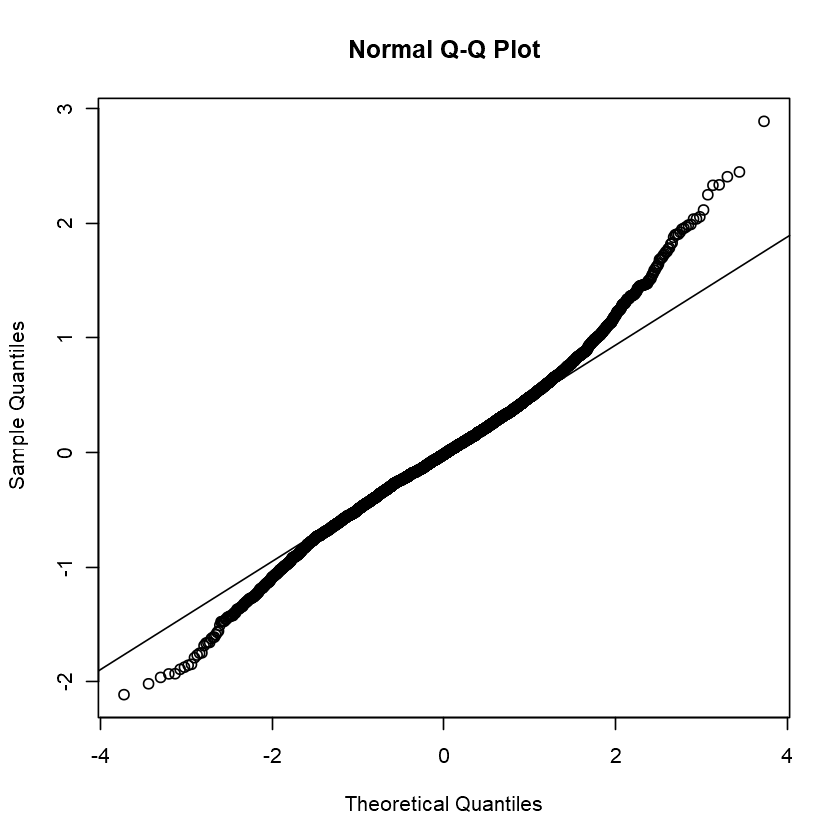

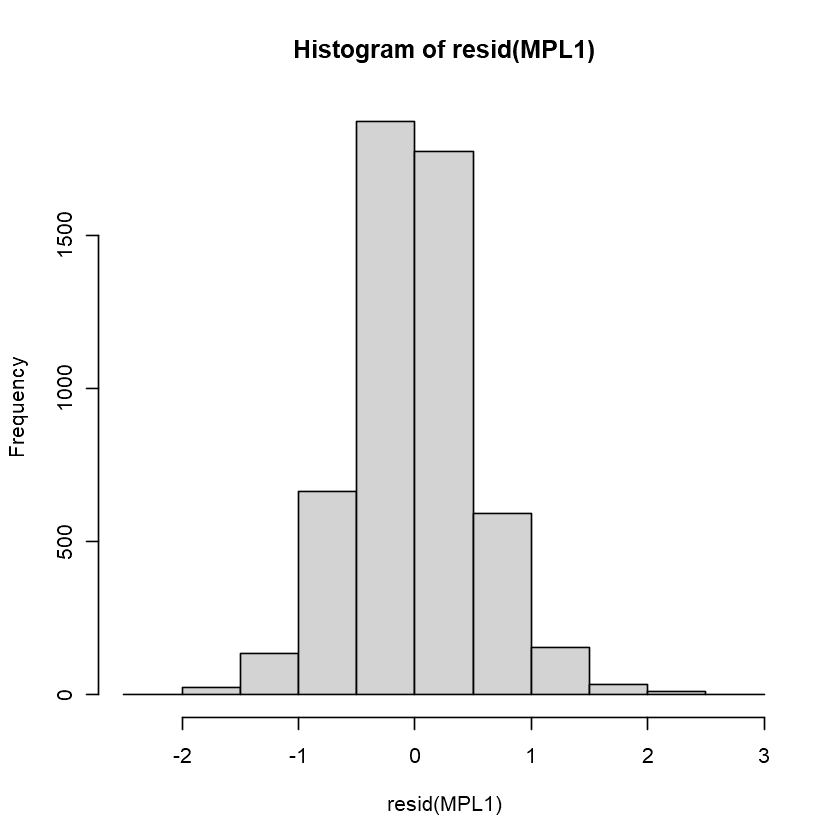

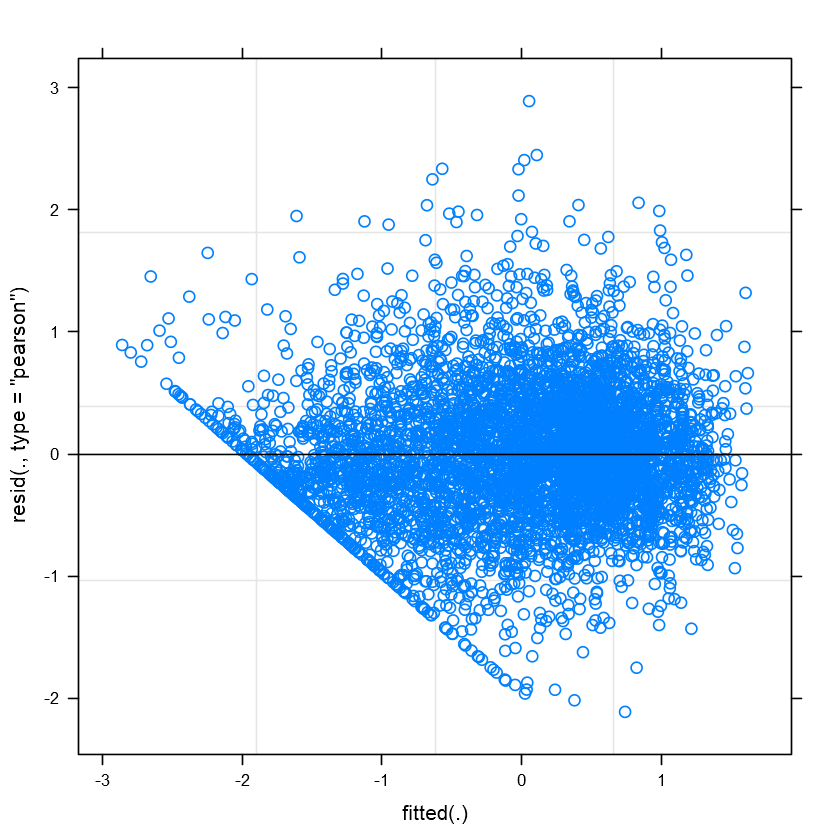

In [19]:
#random interecepts and slopes over DIB for each animal (interactio between DIB and henID as a random effect)
MPL1 = lmer(PC1 ~ cDIB_scale + avgDIB_scale + I(cDIB_scale^2) + Treatment_encoded + temperature_C_avg_scale + (1 + cDIB_scale|HenID), 
                REML=TRUE, data=df)
           #control = lmerControl(optimizer ='optimx', optCtrl=list(method='L-BFGS-B')))
summary(MPL1)
r.squaredGLMM(MPL1)
###### normally distributed residuals
qqnorm(resid(MPL1))
qqline(resid(MPL1))
hist(resid(MPL1))
######check homogeneity of variance (residuals has constant variance)
plot(MPL1)

Linear mixed model fit by REML ['lmerMod']
Formula: 
PC1 ~ cDIB_scale + avgDIB_scale + I(cDIB_scale^2) + Treatment_encoded +  
    temperature_C_avg_scale + (1 + cDIB_scale + I(cDIB_scale^2) |      HenID)
   Data: df

REML criterion at convergence: 9095.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3089 -0.5746 -0.0159  0.5444  5.6480 

Random effects:
 Groups   Name            Variance Std.Dev. Corr       
 HenID    (Intercept)     0.49004  0.7000              
          cDIB_scale      0.14022  0.3745   -0.14      
          I(cDIB_scale^2) 0.04704  0.2169   -0.42 -0.09
 Residual                 0.26185  0.5117              
Number of obs: 5259, groups:  HenID, 130

Fixed effects:
                         Estimate Std. Error t value
(Intercept)              0.234915   0.062452   3.762
cDIB_scale               0.131303   0.033705   3.896
avgDIB_scale             0.093299   0.054998   1.696
I(cDIB_scale^2)         -0.241963   0.020901 -11.577
Treatment_encoded      

R2m,R2c
0.1184806,0.7294692


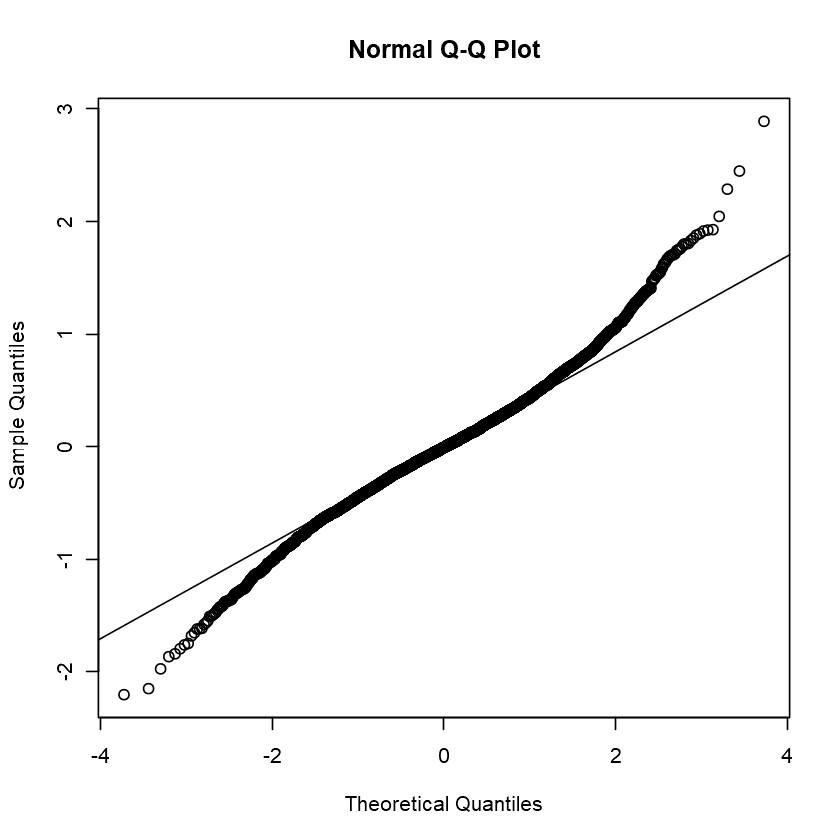

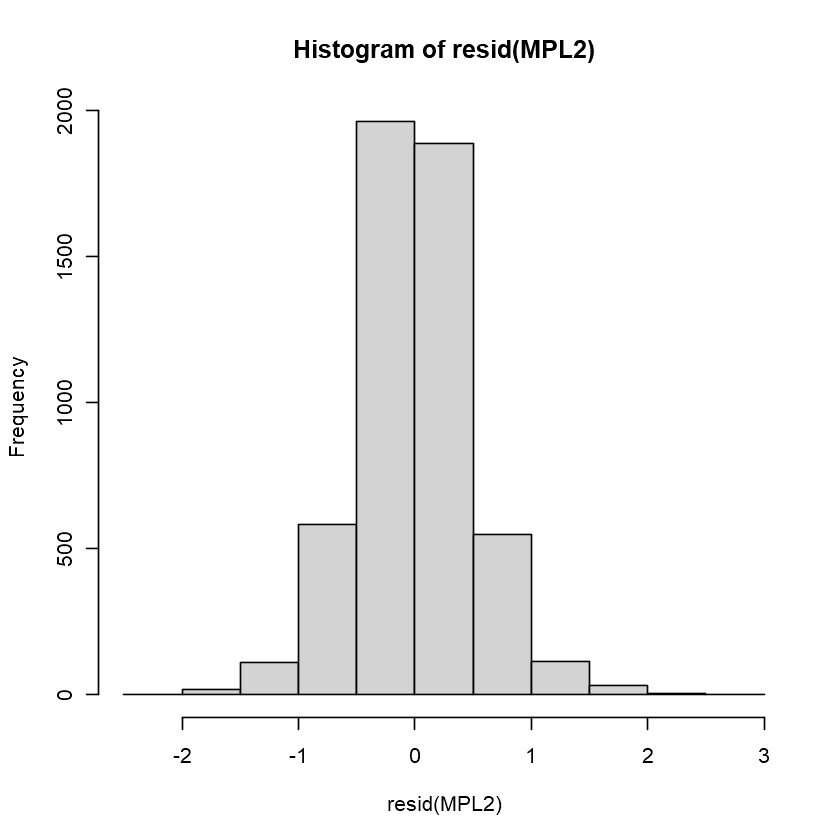

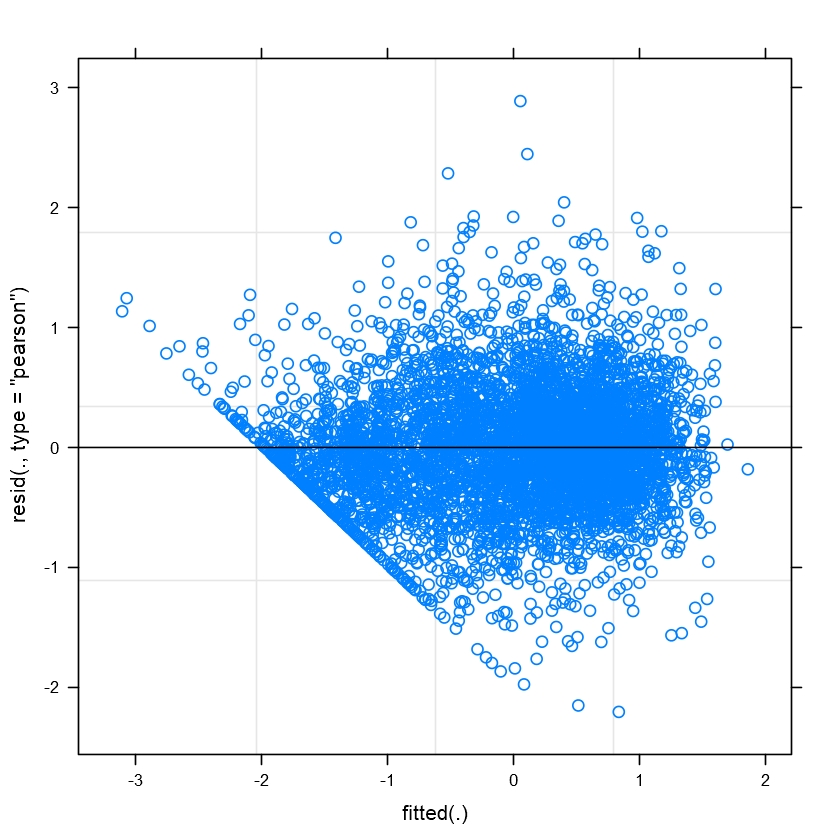

In [20]:
#test whether a nonlinear random slope over DIB improve model fit
MPL2 = lmer(PC1 ~ cDIB_scale + avgDIB_scale + I(cDIB_scale^2) + Treatment_encoded + temperature_C_avg_scale + (1 + cDIB_scale + I(cDIB_scale^2)|HenID), 
                REML=TRUE, data=df)
#control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb'))
summary(MPL2)
r.squaredGLMM(MPL2)
###### normally distributed residuals
qqnorm(resid(MPL2))
qqline(resid(MPL2))
hist(resid(MPL2))
######check homogeneity of variance (residuals has constant variance)
plot(MPL2)

## Comparing models & save corresponding data

In [21]:
#LRT from anova is not correct anymore as we compare parameters that are on the boundery (random effects)
#LRT MAVG2 and MPL1 (i.e. compare  model with the random intercept and the model with random intercept and slope)
#Same as my citation from: https://link.springer.com/content/pdf/10.1007%2F978-0-387-87458-6_5.pdf (chapter 5 of the book)
summary(MAVG2)$logLik
summary(MPL1)$logLik
AIC(MAVG2, MPL1)
L = -2*(summary(MAVG2)$logLik -summary(MPL1)$logLik)
L
pval = 0.5 * ((1 - pchisq(L, df=1)) + (1 - pchisq(L, df=2))) 
pval
#if p-value < 0.001. reject H0, This means that adding random slope to the model is a significant improvement

'log Lik.' -5564.987 (df=8)

'log Lik.' -4797.917 (df=10)

,df,AIC
,<dbl>,<dbl>
MAVG2,8,11145.974
MPL1,10,9615.834


'log Lik.' 1534.14 (df=8)

'log Lik.' 0 (df=8)

In [22]:
#LRT MPL1 and MPL2 (i.e. with DPT compared to DPT2)
#Same as before as its a special case of only one parameter hitting the boundary
#should be correct based on https://stats.stackexchange.com/questions/16013/allowed-comparisons-of-mixed-effects-models-random-effects-primarily/16015#16015
AIC(MPL2, MPL1)
L = -2*(summary(MPL1)$logLik -summary(MPL2)$logLik)
L
pval = 0.5 * ((1 - pchisq(L, df=1)) + (1 - pchisq(L, df=2))) 
pval
#if p-value < 0.001. reject H0, This means that adding quadratic term to the model is a significant improvement: use the more complex model!

,df,AIC
,<dbl>,<dbl>
MPL2,13,9121.296
MPL1,10,9615.834


'log Lik.' 500.5382 (df=10)

'log Lik.' 0 (df=10)

#### daily predicted value

In [23]:
#daily predicted value
df$pred_pop  = predict(MAVG1, re.form = NA) #no random effect
#prediction for the individuals-level "reaction norm"
df$pred_HenID = predict(MAVG1, re.form = NULL)
write.csv(df, file.path(path_,'Adaptability','EstimatedPlasticity_int.csv'), row.names = FALSE)
head(df,3)

,WIB,HenID,RPen,DIB,CLASS,TrackingSystemID,PenID,temperature_C_avg,Treatment,tobeusedPCA,...,avgDIB,cDIB,cDIBfact,InitialWeight_kg,PC1,temperature_C_avg_scale,cDIB_scale,avgDIB_scale,pred_pop,pred_HenID
,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<fct>,<int>,...,<dbl>,<int>,<int>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>
1,2,hen_131,4,11,Other,TrackingSystem 10-12,pen10,11.50000,TRAN,1,...,33.35714,11,11,1.202,0.08344469,0.2072431,-1.835419,-0.3359664,-0.1192762,0.2399460
2,2,hen_131,4,12,Other,TrackingSystem 10-12,pen10,10.16667,TRAN,0,...,33.35714,12,12,1.202,-0.01901373,-0.2122889,-1.754145,-0.3359664,-0.1364388,0.2227834
3,2,hen_131,4,13,Other,TrackingSystem 10-12,pen10,9.00000,TRAN,0,...,33.35714,13,13,1.202,-0.33113438,-0.5793794,-1.672870,-0.3359664,-0.1497356,0.2094866


In [24]:
#daily predicted value
df$pred_pop  = predict(MAVG2, re.form = NA) #no random effect
#prediction for the individuals-level "reaction norm"
df$pred_HenID = predict(MAVG2, re.form = NULL)
write.csv(df, file.path(path_,'Adaptability','EstimatedPlasticity_intquad.csv'), row.names = FALSE)
head(df,3)

,WIB,HenID,RPen,DIB,CLASS,TrackingSystemID,PenID,temperature_C_avg,Treatment,tobeusedPCA,...,avgDIB,cDIB,cDIBfact,InitialWeight_kg,PC1,temperature_C_avg_scale,cDIB_scale,avgDIB_scale,pred_pop,pred_HenID
,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<fct>,<int>,...,<dbl>,<int>,<int>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>
1,2,hen_131,4,11,Other,TrackingSystem 10-12,pen10,11.50000,TRAN,1,...,33.35714,11,11,1.202,0.08344469,0.2072431,-1.835419,-0.3359664,-0.6202685,-0.25863721
2,2,hen_131,4,12,Other,TrackingSystem 10-12,pen10,10.16667,TRAN,0,...,33.35714,12,12,1.202,-0.01901373,-0.2122889,-1.754145,-0.3359664,-0.5300516,-0.16842032
3,2,hen_131,4,13,Other,TrackingSystem 10-12,pen10,9.00000,TRAN,0,...,33.35714,13,13,1.202,-0.33113438,-0.5793794,-1.672870,-0.3359664,-0.4443623,-0.08273098


In [25]:
#daily predicted value
df$pred_pop  = predict(MPL1, re.form = NA) #no random effect
#prediction for the individuals-level "reaction norm"
df$pred_HenID = predict(MPL1, re.form = NULL)
write.csv(df, file.path(path_,'Adaptability','EstimatedPlasticity_curve.csv'), row.names = FALSE)
head(df,3)

,WIB,HenID,RPen,DIB,CLASS,TrackingSystemID,PenID,temperature_C_avg,Treatment,tobeusedPCA,...,avgDIB,cDIB,cDIBfact,InitialWeight_kg,PC1,temperature_C_avg_scale,cDIB_scale,avgDIB_scale,pred_pop,pred_HenID
,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<fct>,<int>,...,<dbl>,<int>,<int>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>
1,2,hen_131,4,11,Other,TrackingSystem 10-12,pen10,11.50000,TRAN,1,...,33.35714,11,11,1.202,0.08344469,0.2072431,-1.835419,-0.3359664,-0.6451048,-0.05270543
2,2,hen_131,4,12,Other,TrackingSystem 10-12,pen10,10.16667,TRAN,0,...,33.35714,12,12,1.202,-0.01901373,-0.2122889,-1.754145,-0.3359664,-0.5532738,0.02950019
3,2,hen_131,4,13,Other,TrackingSystem 10-12,pen10,9.00000,TRAN,0,...,33.35714,13,13,1.202,-0.33113438,-0.5793794,-1.672870,-0.3359664,-0.4660542,0.10709433


In [26]:
#done in "phenotypic plant..."
#daily predicted value
df$pred_pop  = predict(MPL2, re.form = NA) #no random effect
#prediction for the individuals-level "reaction norm"
df$pred_HenID = predict(MPL2, re.form = NULL)
write.csv(df, file.path(path_,'Adaptability','EstimatedPlasticity.csv'), row.names = FALSE)
head(df,3)

,WIB,HenID,RPen,DIB,CLASS,TrackingSystemID,PenID,temperature_C_avg,Treatment,tobeusedPCA,...,avgDIB,cDIB,cDIBfact,InitialWeight_kg,PC1,temperature_C_avg_scale,cDIB_scale,avgDIB_scale,pred_pop,pred_HenID
,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<fct>,<int>,...,<dbl>,<int>,<int>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>
1,2,hen_131,4,11,Other,TrackingSystem 10-12,pen10,11.50000,TRAN,1,...,33.35714,11,11,1.202,0.08344469,0.2072431,-1.835419,-0.3359664,-0.6686060,-0.2521261
2,2,hen_131,4,12,Other,TrackingSystem 10-12,pen10,10.16667,TRAN,0,...,33.35714,12,12,1.202,-0.01901373,-0.2122889,-1.754145,-0.3359664,-0.5752177,-0.1433959
3,2,hen_131,4,13,Other,TrackingSystem 10-12,pen10,9.00000,TRAN,0,...,33.35714,13,13,1.202,-0.33113438,-0.5793794,-1.672870,-0.3359664,-0.4865418,-0.0405486


#### BLUP: individual estimates with uncertainty values

In [27]:
set.seed(1)
#REsim already synthesis results compare to the sim(). I verified manually
simulated_individualplasticity = REsim(MPL2, n.sim = 1000)
head(simulated_individualplasticity,3)
write.csv(simulated_individualplasticity, file.path(path_,'Adaptability','IndividualPlasticity.csv'), row.names = FALSE)

,groupFctr,groupID,term,mean,median,sd
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,HenID,hen_1,(Intercept),-1.0800167,-1.0767482,0.1721861
2,HenID,hen_10,(Intercept),-0.5455325,-0.5441738,0.1608157
3,HenID,hen_101,(Intercept),0.5992357,0.5976207,0.1764600


# Predictibility

In [28]:
#Get information on all parameters (and parameter classes) for which priors may be specified including default priors:
get_prior(formula= PC1~ cDIB_scale + avgDIB_scale + I(cDIB_scale^2) + Treatment_encoded + temperature_C_avg_scale + (1+ cDIB_scale + I(cDIB_scale^2)|HenID), 
          data=df, family = gaussian())

prior,class,coef,group,resp,dpar,nlpar,bound,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,default
,b,avgDIB_scale,,,,,,default
,b,cDIB_scale,,,,,,default
,b,IcDIB_scaleE2,,,,,,default
,b,temperature_C_avg_scale,,,,,,default
,b,Treatment_encoded,,,,,,default
lkj(1),cor,,,,,,,default
,cor,,HenID,,,,,default
"student_t(3, 0.2, 2.5)",Intercept,,,,,,,default


Compiling Stan program...

Start sampling



 Family: gaussian 
  Links: mu = identity; sigma = log 
Formula: PC1 ~ cDIB_scale + avgDIB_scale + I(cDIB_scale^2) + Treatment_encoded + temperature_C_avg_scale + (1 + cDIB_scale + I(cDIB_scale^2) | HenID) 
         sigma ~ (1 | HenID)
   Data: df (Number of observations: 5259) 
  Draws: 10 chains, each with iter = 5000; warmup = 2500; thin = 3;
         total post-warmup draws = 8334

Group-Level Effects: 
~HenID (Number of levels: 130) 
                              Estimate Est.Error l-95% CI u-95% CI Rhat
sd(Intercept)                     0.71      0.05     0.63     0.81 1.00
sd(cDIB_scale)                    0.38      0.03     0.33     0.43 1.00
sd(IcDIB_scaleE2)                 0.21      0.02     0.18     0.24 1.00
sd(sigma_Intercept)               0.30      0.02     0.26     0.35 1.00
cor(Intercept,cDIB_scale)        -0.14      0.09    -0.31     0.04 1.00
cor(Intercept,IcDIB_scaleE2)     -0.41      0.08    -0.56    -0.24 1.00
cor(cDIB_scale,IcDIB_scaleE2)    -0.09      0.10    -

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


[1] 0.3086844

,lower,upper
var1,0.2650131,0.3579437


prior,class,coef,group,resp,dpar,nlpar,bound,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,default
,b,avgDIB_scale,,,,,,default
,b,cDIB_scale,,,,,,default
,b,IcDIB_scaleE2,,,,,,default
,b,temperature_C_avg_scale,,,,,,default
,b,Treatment_encoded,,,,,,default
"student_t(3, 0.2, 2.5)",Intercept,,,,,,,default
"student_t(3, 0, 2.5)",Intercept,,,,sigma,,,default
lkj_corr_cholesky(1),L,,,,,,,default


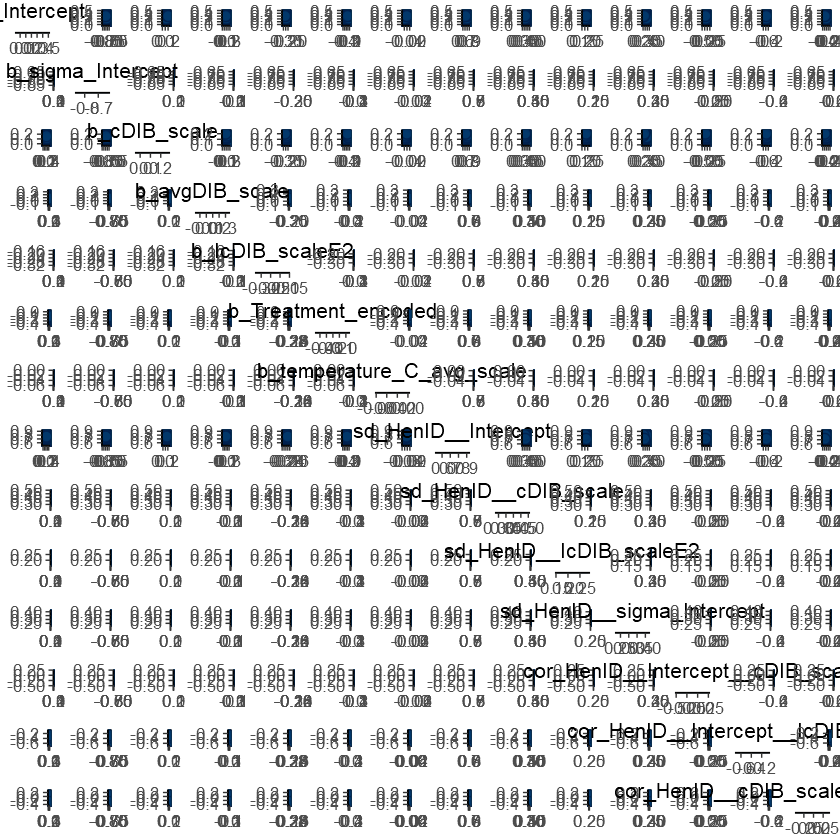

In [29]:
#help(brms) #to cite STAN for the following info:
### bulk-ESS: We recommend requiring that the bulk-ESS is greater than 100 times the number of chains. For example, when running 
#4 chains, this corresponds to having a rank-normalized effective sample size of at least 400.
### R-hat: We recommend running at least four chains by default and only using the sample if R-hat is less than 1.01.
#more info: #https://mc-stan.org/misc/warnings.html#bulk-ess%22
double_model = bf(PC1~ cDIB_scale + avgDIB_scale + I(cDIB_scale^2) + Treatment_encoded + temperature_C_avg_scale + (1+cDIB_scale + I(cDIB_scale^2)|HenID), 
                  sigma~(1|HenID))
modelPred = brm(double_model, data=df, iter=15000, inits="random", seed=12345, control = list(max_treedepth = 15), 
                cores=my.cores, chains=10, thin=3)
             #prior = c(set_prior("student_t(1, 0.01, 0.001)", coef = "temperature_C_avg_scale"),
             #         set_prior("student_t(1, 0.01, 0.001)", coef = "cDIB_scale")))
#modelPred = add_criterion(modelPred, "waic")
summary(modelPred)
pairs(modelPred)
#head(get_variables(modelPred),10)

#coefficient of variation in predictability” (CVP)
log.norm.res = exp(posterior_samples(modelPred)$"sd_HenID__sigma_Intercept"^2)
CVP = sqrt(log.norm.res-1)
mean(CVP);HPDinterval(as.mcmc(CVP),0.95)
#df_pred = posterior_samples(modelPred) #depreciated but still work well. we will instead use:
#extract samples (draw) from the posterior distribution, including all variables
df_pred = as_draws(modelPred)
write.csv(df_pred, file.path(path_,'Adaptability','IndividualPredictability_avgDIB.csv'), row.names = FALSE)
prior_summary(modelPred)

In [30]:
#mean population-level residual variance
fixef(modelPred, pars = "sigma_Intercept")[1]

[1] -0.7457803

In [31]:
#add score and save model
add_criterion(modelPred, criterion='bayes_R2', file=file.path(path_adapt,'BRMS_Model_variance_avgDIB_scale'))
#model can be retrieve like this: 
#modelPred = readRDS(file.path(path_adapt,'BRMS_Model_variance_avgDIB_scale.rds'))
#summary(modelPred)

 Family: gaussian 
  Links: mu = identity; sigma = log 
Formula: PC1 ~ cDIB_scale + avgDIB_scale + I(cDIB_scale^2) + Treatment_encoded + temperature_C_avg_scale + (1 + cDIB_scale + I(cDIB_scale^2) | HenID) 
         sigma ~ (1 | HenID)
   Data: df (Number of observations: 5259) 
  Draws: 10 chains, each with iter = 5000; warmup = 2500; thin = 3;
         total post-warmup draws = 8334

Group-Level Effects: 
~HenID (Number of levels: 130) 
                              Estimate Est.Error l-95% CI u-95% CI Rhat
sd(Intercept)                     0.71      0.05     0.63     0.81 1.00
sd(cDIB_scale)                    0.38      0.03     0.33     0.43 1.00
sd(IcDIB_scaleE2)                 0.21      0.02     0.18     0.24 1.00
sd(sigma_Intercept)               0.30      0.02     0.26     0.35 1.00
cor(Intercept,cDIB_scale)        -0.14      0.09    -0.31     0.04 1.00
cor(Intercept,IcDIB_scaleE2)     -0.41      0.08    -0.56    -0.24 1.00
cor(cDIB_scale,IcDIB_scaleE2)    -0.09      0.10    -

In [26]:
#https://bookdown.org/marklhc/notes_bookdown/model-diagnostics.html

#### posterior predictive check

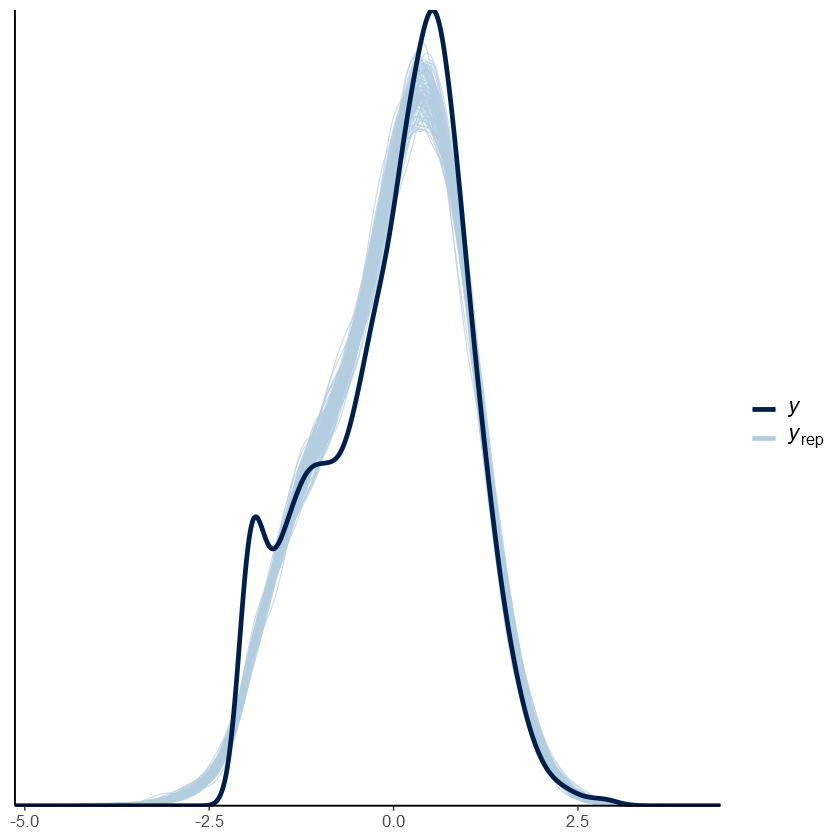

In [32]:
pp_check(modelPred, ndraws = 100)
#-->we don't see any major systematic discrepancies of our data from what can be predicted with modelPred

In [28]:
#additonally marginal model plots could be done with : https://github.com/marklhc/usc-psyc621-notes/blob/master/mmp_brm.R
#as explained here: https://bookdown.org/marklhc/notes_bookdown/model-diagnostics.html#diagnostic-tools